# About this notebook  
- PyTorch resnext50_32x4d starter code  
- StratifiedKFold 5 folds  

If this notebook is helpful, feel free to upvote :)

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True

# Data Loading

In [2]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
os.listdir("../input/cassava-leaf-disease-classification")

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'train_tfrecords',
 'test_tfrecords',
 'test_images',
 'train_images',
 'train.csv']

In [4]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")
display(train.head())
display(test.head())
display(label_map)

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/home/ubuntu/work/pytorch/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

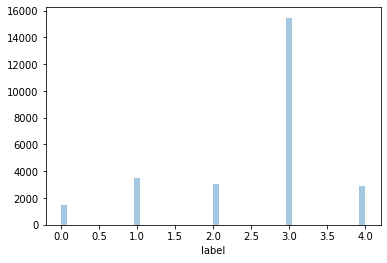

In [5]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = False
    print_freq = 100
    num_workers = 4
    model_name = "resnext50_32x4d"
    size = 512  # 512 if ON_KAGGLE else 384
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.05
    scheduler = (
        "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    )
    epochs = 10
    # factor=0.2 # ReduceLROnPlateau
    # patience=4 # ReduceLROnPlateau
    # eps=1e-6 # ReduceLROnPlateau
    # T_max=10 # CosineAnnealingLR
    T_0 = 10  # CosineAnnealingWarmRestarts
    lr = 1e-4
    min_lr = 1e-6
    batch_size = 14
    weight_decay = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    seed = 22
    target_size = 5
    target_col = "label"
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/bitemperedlogloss/")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    Compose,
    Cutout,
    HorizontalFlip,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [10]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         299
      1         695
      2         604
      3        3092
      4         578
1     0         299
      1         695
      2         604
      3        3092
      4         578
2     0         298
      1         695
      2         603
      3        3093
      4         578
3     0         298
      1         695
      2         603
      3        3093
      4         578
4     0         298
      1         696
      2         603
      3        3092
      4         578
dtype: int64


# Dataset

In [11]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).long()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

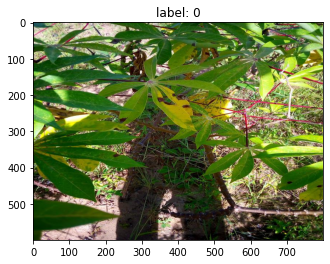

In [12]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [13]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

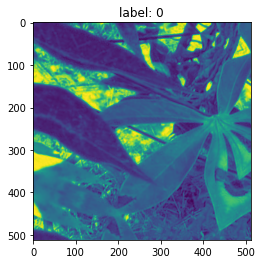

In [14]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# MODEL

In [15]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [16]:
model = CustomResNext(model_name=CFG.model_name, pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.1549, -0.0089,  0.0330,  0.0390, -0.3349],
        [ 0.1110,  0.1037, -0.0444, -0.0676, -0.5088],
        [ 0.2024,  0.1188,  0.1331,  0.1483, -0.1627],
        [ 0.2517,  0.0700,  0.1259, -0.0479, -0.1377]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [17]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f}  "
                #'LR: {lr:.6f}  '
                .format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    # lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [19]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda"):
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [20]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CustomResNext(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [21]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/1504] Data 0.503 (0.503) Elapsed 0m 4s (remain 100m 12s) Loss: 0.5103(0.5103) Grad: 2.6407  
Epoch: [1][100/1504] Data 0.000 (0.005) Elapsed 2m 15s (remain 31m 21s) Loss: 0.2944(0.2904) Grad: 3.6892  
Epoch: [1][200/1504] Data 0.000 (0.003) Elapsed 4m 26s (remain 28m 50s) Loss: 0.1597(0.2582) Grad: 2.5196  
Epoch: [1][300/1504] Data 0.000 (0.002) Elapsed 6m 38s (remain 26m 31s) Loss: 0.0908(0.2431) Grad: 2.4672  
Epoch: [1][400/1504] Data 0.000 (0.001) Elapsed 8m 49s (remain 24m 17s) Loss: 0.3009(0.2314) Grad: 3.3226  
Epoch: [1][500/1504] Data 0.000 (0.001) Elapsed 11m 1s (remain 22m 3s) Loss: 0.2236(0.2227) Grad: 2.7766  
Epoch: [1][600/1504] Data 0.000 (0.001) Elapsed 13m 12s (remain 19m 50s) Loss: 0.2051(0.2165) Grad: 3.0786  
Epoch: [1][700/1504] Data 0.000 (0.001) Elapsed 15m 24s (remain 17m 38s) Loss: 0.0549(0.2129) Grad: 2.3625  
Epoch: [1][800/1504] Data 0.000 (0.001) Elapsed 17m 35s (remain 15m 26s) Loss: 0.2011(0.2108) Grad: 3.0286  
Epoch: [1][900/1504] Data 0.

Epoch 1 - avg_train_loss: 0.1937  avg_val_loss: 0.1313  time: 2109s
Epoch 1 - Accuracy: 0.8578208048595293
Epoch 1 - Save Best Score: 0.8578 Model


EVAL: [376/377] Data 0.000 (0.002) Elapsed 2m 9s (remain 0m 0s) Loss: 0.1991(0.1313) 
Epoch: [2][0/1504] Data 0.496 (0.496) Elapsed 0m 1s (remain 46m 2s) Loss: 0.2391(0.2391) Grad: 2.7694  
Epoch: [2][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 50s) Loss: 0.1650(0.1585) Grad: 1.6471  
Epoch: [2][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 35s) Loss: 0.0467(0.1639) Grad: 0.8053  
Epoch: [2][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 23s) Loss: 0.2451(0.1607) Grad: 2.7336  
Epoch: [2][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 10s) Loss: 0.1971(0.1637) Grad: 3.9458  
Epoch: [2][500/1504] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 58s) Loss: 0.1697(0.1635) Grad: 1.5757  
Epoch: [2][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.1187(0.1631) Grad: 0.7748  
Epoch: [2][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 35s) Loss: 0.0401(0.1598) Grad: 1.2622  
Epoch: [2][800/1504] Data 0.000 (0.001) Elapsed 17m

Epoch 2 - avg_train_loss: 0.1549  avg_val_loss: 0.1221  time: 2106s
Epoch 2 - Accuracy: 0.8642748671222475
Epoch 2 - Save Best Score: 0.8643 Model


EVAL: [376/377] Data 0.000 (0.002) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0397(0.1221) 
Epoch: [3][0/1504] Data 0.483 (0.483) Elapsed 0m 1s (remain 45m 30s) Loss: 0.0057(0.0057) Grad: 0.2519  
Epoch: [3][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 49s) Loss: 0.0073(0.1481) Grad: 0.3378  
Epoch: [3][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 35s) Loss: 0.3481(0.1465) Grad: 2.3604  
Epoch: [3][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 22s) Loss: 0.1330(0.1474) Grad: 1.1330  
Epoch: [3][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 10s) Loss: 0.1508(0.1463) Grad: 2.3788  
Epoch: [3][500/1504] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 58s) Loss: 0.1309(0.1469) Grad: 1.8618  
Epoch: [3][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.1977(0.1440) Grad: 1.0242  
Epoch: [3][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 35s) Loss: 0.1326(0.1442) Grad: 1.8662  
Epoch: [3][800/1504] Data 0.000 (0.001) Elapsed 17

Epoch 3 - avg_train_loss: 0.1444  avg_val_loss: 0.1380  time: 2106s
Epoch 3 - Accuracy: 0.8490888382687927


EVAL: [376/377] Data 0.000 (0.002) Elapsed 2m 9s (remain 0m 0s) Loss: 0.1970(0.1380) 
Epoch: [4][0/1504] Data 0.543 (0.543) Elapsed 0m 1s (remain 46m 56s) Loss: 0.0712(0.0712) Grad: 1.1386  
Epoch: [4][100/1504] Data 0.000 (0.006) Elapsed 2m 13s (remain 30m 49s) Loss: 0.0894(0.1469) Grad: 0.7414  
Epoch: [4][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 34s) Loss: 0.1752(0.1364) Grad: 1.5385  
Epoch: [4][300/1504] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 21s) Loss: 0.0672(0.1333) Grad: 0.6698  
Epoch: [4][400/1504] Data 0.000 (0.002) Elapsed 8m 47s (remain 24m 9s) Loss: 0.1690(0.1365) Grad: 1.2414  
Epoch: [4][500/1504] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 58s) Loss: 0.1593(0.1349) Grad: 2.1888  
Epoch: [4][600/1504] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 46s) Loss: 0.1625(0.1333) Grad: 0.9856  
Epoch: [4][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 35s) Loss: 0.2134(0.1349) Grad: 1.1747  
Epoch: [4][800/1504] Data 0.000 (0.001) Elapsed 17m 

Epoch 4 - avg_train_loss: 0.1350  avg_val_loss: 0.1283  time: 2105s
Epoch 4 - Accuracy: 0.8604783599088838


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0645(0.1283) 
Epoch: [5][0/1504] Data 0.470 (0.470) Elapsed 0m 1s (remain 45m 5s) Loss: 0.1644(0.1644) Grad: 1.2955  
Epoch: [5][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 50s) Loss: 0.0719(0.1340) Grad: 0.5788  
Epoch: [5][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 36s) Loss: 0.1674(0.1294) Grad: 1.4056  
Epoch: [5][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 23s) Loss: 0.2107(0.1341) Grad: 1.7841  
Epoch: [5][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 10s) Loss: 0.3194(0.1317) Grad: 2.7838  
Epoch: [5][500/1504] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.0284(0.1318) Grad: 0.5535  
Epoch: [5][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.0359(0.1332) Grad: 0.9606  
Epoch: [5][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 35s) Loss: 0.1585(0.1324) Grad: 1.4272  
Epoch: [5][800/1504] Data 0.000 (0.001) Elapsed 17m

Epoch 5 - avg_train_loss: 0.1308  avg_val_loss: 0.1134  time: 2107s
Epoch 5 - Accuracy: 0.8809794988610479
Epoch 5 - Save Best Score: 0.8810 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.3202(0.1134) 
Epoch: [6][0/1504] Data 0.466 (0.466) Elapsed 0m 1s (remain 45m 17s) Loss: 0.0490(0.0490) Grad: 1.7602  
Epoch: [6][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 49s) Loss: 0.1152(0.1258) Grad: 1.4510  
Epoch: [6][200/1504] Data 0.000 (0.002) Elapsed 4m 24s (remain 28m 35s) Loss: 0.1244(0.1258) Grad: 1.2758  
Epoch: [6][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 23s) Loss: 0.1134(0.1253) Grad: 3.3224  
Epoch: [6][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0744(0.1238) Grad: 1.6568  
Epoch: [6][500/1504] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.2668(0.1222) Grad: 1.2350  
Epoch: [6][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.0940(0.1205) Grad: 1.1789  
Epoch: [6][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 35s) Loss: 0.1197(0.1202) Grad: 1.6210  
Epoch: [6][800/1504] Data 0.000 (0.001) Elapsed 17

Epoch 6 - avg_train_loss: 0.1221  avg_val_loss: 0.1315  time: 2107s
Epoch 6 - Accuracy: 0.8563022019741837


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0213(0.1315) 
Epoch: [7][0/1504] Data 0.477 (0.477) Elapsed 0m 1s (remain 45m 19s) Loss: 0.1618(0.1618) Grad: 1.3806  
Epoch: [7][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 51s) Loss: 0.1032(0.1035) Grad: 1.0333  
Epoch: [7][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 35s) Loss: 0.2411(0.1060) Grad: 1.4247  
Epoch: [7][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 23s) Loss: 0.2988(0.1103) Grad: 1.6151  
Epoch: [7][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0737(0.1151) Grad: 1.2479  
Epoch: [7][500/1504] Data 0.000 (0.001) Elapsed 10m 59s (remain 21m 59s) Loss: 0.0975(0.1138) Grad: 1.7309  
Epoch: [7][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.0728(0.1152) Grad: 1.3323  
Epoch: [7][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.3347(0.1148) Grad: 1.0468  
Epoch: [7][800/1504] Data 0.000 (0.001) Elapsed 17

Epoch 7 - avg_train_loss: 0.1151  avg_val_loss: 0.1061  time: 2107s
Epoch 7 - Accuracy: 0.8874335611237661
Epoch 7 - Save Best Score: 0.8874 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.3090(0.1061) 
Epoch: [8][0/1504] Data 0.503 (0.503) Elapsed 0m 1s (remain 46m 0s) Loss: 0.1764(0.1764) Grad: 2.7782  
Epoch: [8][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 52s) Loss: 0.1045(0.1077) Grad: 1.5742  
Epoch: [8][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 36s) Loss: 0.0643(0.1120) Grad: 2.0600  
Epoch: [8][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 23s) Loss: 0.1326(0.1142) Grad: 1.0167  
Epoch: [8][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0542(0.1139) Grad: 1.2258  
Epoch: [8][500/1504] Data 0.000 (0.001) Elapsed 10m 59s (remain 21m 59s) Loss: 0.1188(0.1145) Grad: 1.3459  
Epoch: [8][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.1405(0.1156) Grad: 1.5815  
Epoch: [8][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 35s) Loss: 0.1490(0.1145) Grad: 0.9968  
Epoch: [8][800/1504] Data 0.000 (0.001) Elapsed 17m

Epoch 8 - avg_train_loss: 0.1117  avg_val_loss: 0.1062  time: 2107s
Epoch 8 - Accuracy: 0.8872437357630979


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.2461(0.1062) 
Epoch: [9][0/1504] Data 0.502 (0.502) Elapsed 0m 1s (remain 45m 54s) Loss: 0.1572(0.1572) Grad: 1.3273  
Epoch: [9][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 51s) Loss: 0.1857(0.1103) Grad: 1.2658  
Epoch: [9][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 36s) Loss: 0.1547(0.1100) Grad: 1.9728  
Epoch: [9][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 23s) Loss: 0.0816(0.1078) Grad: 1.0675  
Epoch: [9][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0769(0.1057) Grad: 1.7846  
Epoch: [9][500/1504] Data 0.000 (0.001) Elapsed 10m 59s (remain 21m 59s) Loss: 0.2264(0.1070) Grad: 2.2097  
Epoch: [9][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.0568(0.1074) Grad: 1.1793  
Epoch: [9][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.1874(0.1086) Grad: 2.1633  
Epoch: [9][800/1504] Data 0.000 (0.001) Elapsed 17

Epoch 9 - avg_train_loss: 0.1052  avg_val_loss: 0.1065  time: 2107s
Epoch 9 - Accuracy: 0.8883826879271071
Epoch 9 - Save Best Score: 0.8884 Model


EVAL: [376/377] Data 0.000 (0.002) Elapsed 2m 9s (remain 0m 0s) Loss: 0.2335(0.1065) 
Epoch: [10][0/1504] Data 0.506 (0.506) Elapsed 0m 1s (remain 46m 3s) Loss: 0.2043(0.2043) Grad: 1.3944  
Epoch: [10][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 51s) Loss: 0.1494(0.1067) Grad: 2.1979  
Epoch: [10][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 36s) Loss: 0.0705(0.1031) Grad: 1.2307  
Epoch: [10][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 23s) Loss: 0.0743(0.1046) Grad: 0.8702  
Epoch: [10][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0965(0.1025) Grad: 0.7466  
Epoch: [10][500/1504] Data 0.000 (0.001) Elapsed 10m 59s (remain 21m 59s) Loss: 0.1091(0.1043) Grad: 1.2852  
Epoch: [10][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.0326(0.1049) Grad: 0.9556  
Epoch: [10][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.0975(0.1060) Grad: 1.6401  
Epoch: [10][800/1504] Data 0.000 (0.001) El

Epoch 10 - avg_train_loss: 0.1031  avg_val_loss: 0.1060  time: 2107s
Epoch 10 - Accuracy: 0.8900911161731208
Epoch 10 - Save Best Score: 0.8901 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.2721(0.1060) 


========== fold: 0 result ==========
Score: 0.89009
========== fold: 1 training ==========


Epoch: [1][0/1504] Data 0.470 (0.470) Elapsed 0m 1s (remain 45m 22s) Loss: 0.5361(0.5361) Grad: 2.4103  
Epoch: [1][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 51s) Loss: 0.1243(0.2891) Grad: 1.7932  
Epoch: [1][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 35s) Loss: 0.2721(0.2576) Grad: 3.2120  
Epoch: [1][300/1504] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 22s) Loss: 0.0836(0.2398) Grad: 1.5238  
Epoch: [1][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 10s) Loss: 0.4739(0.2326) Grad: 4.1593  
Epoch: [1][500/1504] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 58s) Loss: 0.2361(0.2273) Grad: 3.3233  
Epoch: [1][600/1504] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 46s) Loss: 0.0986(0.2208) Grad: 2.0870  
Epoch: [1][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 35s) Loss: 0.1543(0.2139) Grad: 2.2922  
Epoch: [1][800/1504] Data 0.000 (0.001) Elapsed 17m 32s (remain 15m 23s) Loss: 0.2475(0.2112) Grad: 2.0686  
Epoch: [1][900/1504] Data 0.

Epoch 1 - avg_train_loss: 0.1932  avg_val_loss: 0.1369  time: 2106s
Epoch 1 - Accuracy: 0.8553530751708428
Epoch 1 - Save Best Score: 0.8554 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0233(0.1369) 
Epoch: [2][0/1504] Data 0.477 (0.477) Elapsed 0m 1s (remain 45m 21s) Loss: 0.1532(0.1532) Grad: 0.7786  
Epoch: [2][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 51s) Loss: 0.1389(0.1515) Grad: 2.3428  
Epoch: [2][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 36s) Loss: 0.2084(0.1575) Grad: 1.4244  
Epoch: [2][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 23s) Loss: 0.2315(0.1564) Grad: 2.7053  
Epoch: [2][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.1056(0.1556) Grad: 2.1243  
Epoch: [2][500/1504] Data 0.000 (0.001) Elapsed 10m 59s (remain 21m 59s) Loss: 0.1944(0.1590) Grad: 3.2322  
Epoch: [2][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.2382(0.1593) Grad: 1.9123  
Epoch: [2][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.1223(0.1579) Grad: 1.7358  
Epoch: [2][800/1504] Data 0.000 (0.001) Elapsed 17

Epoch 2 - avg_train_loss: 0.1544  avg_val_loss: 0.1312  time: 2107s
Epoch 2 - Accuracy: 0.8587699316628702
Epoch 2 - Save Best Score: 0.8588 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0784(0.1312) 
Epoch: [3][0/1504] Data 0.481 (0.481) Elapsed 0m 1s (remain 45m 27s) Loss: 0.1679(0.1679) Grad: 1.2857  
Epoch: [3][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 50s) Loss: 0.2396(0.1446) Grad: 2.1007  
Epoch: [3][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 34s) Loss: 0.0825(0.1488) Grad: 1.7349  
Epoch: [3][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 22s) Loss: 0.0875(0.1477) Grad: 1.9936  
Epoch: [3][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 10s) Loss: 0.2326(0.1477) Grad: 1.2601  
Epoch: [3][500/1504] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 58s) Loss: 0.1204(0.1495) Grad: 1.5191  
Epoch: [3][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.1268(0.1486) Grad: 2.3797  
Epoch: [3][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 35s) Loss: 0.0859(0.1472) Grad: 1.5581  
Epoch: [3][800/1504] Data 0.000 (0.001) Elapsed 17

Epoch 3 - avg_train_loss: 0.1453  avg_val_loss: 0.1226  time: 2107s
Epoch 3 - Accuracy: 0.8709187547456341
Epoch 3 - Save Best Score: 0.8709 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0816(0.1226) 
Epoch: [4][0/1504] Data 0.466 (0.466) Elapsed 0m 1s (remain 44m 58s) Loss: 0.2133(0.2133) Grad: 1.6583  
Epoch: [4][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 50s) Loss: 0.0766(0.1356) Grad: 1.2354  
Epoch: [4][200/1504] Data 0.000 (0.002) Elapsed 4m 24s (remain 28m 36s) Loss: 0.1050(0.1396) Grad: 1.0854  
Epoch: [4][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 23s) Loss: 0.0412(0.1424) Grad: 1.2684  
Epoch: [4][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.1392(0.1420) Grad: 1.2848  
Epoch: [4][500/1504] Data 0.000 (0.001) Elapsed 10m 59s (remain 21m 59s) Loss: 0.1823(0.1412) Grad: 1.7581  
Epoch: [4][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.1497(0.1389) Grad: 2.0241  
Epoch: [4][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.2078(0.1384) Grad: 1.2672  
Epoch: [4][800/1504] Data 0.000 (0.001) Elapsed 17

Epoch 4 - avg_train_loss: 0.1362  avg_val_loss: 0.1205  time: 2107s
Epoch 4 - Accuracy: 0.8675018982536067


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0152(0.1205) 
Epoch: [5][0/1504] Data 0.493 (0.493) Elapsed 0m 1s (remain 45m 44s) Loss: 0.1172(0.1172) Grad: 0.6887  
Epoch: [5][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 49s) Loss: 0.1246(0.1369) Grad: 0.9390  
Epoch: [5][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 34s) Loss: 0.0591(0.1302) Grad: 1.3147  
Epoch: [5][300/1504] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 21s) Loss: 0.1410(0.1299) Grad: 1.4348  
Epoch: [5][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 9s) Loss: 0.0980(0.1288) Grad: 1.6763  
Epoch: [5][500/1504] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 58s) Loss: 0.0884(0.1263) Grad: 1.7913  
Epoch: [5][600/1504] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 46s) Loss: 0.2461(0.1273) Grad: 1.6195  
Epoch: [5][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 35s) Loss: 0.2969(0.1284) Grad: 2.2520  
Epoch: [5][800/1504] Data 0.000 (0.001) Elapsed 17m 

Epoch 5 - avg_train_loss: 0.1267  avg_val_loss: 0.1172  time: 2105s
Epoch 5 - Accuracy: 0.8750949126803341
Epoch 5 - Save Best Score: 0.8751 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0197(0.1172) 
Epoch: [6][0/1504] Data 0.480 (0.480) Elapsed 0m 1s (remain 45m 21s) Loss: 0.0562(0.0562) Grad: 1.0463  
Epoch: [6][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 52s) Loss: 0.1498(0.1218) Grad: 1.6425  
Epoch: [6][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 35s) Loss: 0.0938(0.1287) Grad: 1.3299  
Epoch: [6][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 22s) Loss: 0.0972(0.1239) Grad: 1.3430  
Epoch: [6][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 10s) Loss: 0.0992(0.1219) Grad: 1.2435  
Epoch: [6][500/1504] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.1385(0.1219) Grad: 2.4815  
Epoch: [6][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.0697(0.1207) Grad: 1.1287  
Epoch: [6][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 35s) Loss: 0.1358(0.1235) Grad: 1.1798  
Epoch: [6][800/1504] Data 0.000 (0.001) Elapsed 17

Epoch 6 - avg_train_loss: 0.1225  avg_val_loss: 0.1163  time: 2107s
Epoch 6 - Accuracy: 0.8731966590736523


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0103(0.1163) 
Epoch: [7][0/1504] Data 0.490 (0.490) Elapsed 0m 1s (remain 45m 45s) Loss: 0.0730(0.0730) Grad: 1.2254  
Epoch: [7][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 51s) Loss: 0.0803(0.1011) Grad: 1.5311  
Epoch: [7][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 36s) Loss: 0.2796(0.1137) Grad: 1.7982  
Epoch: [7][300/1504] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 23s) Loss: 0.0498(0.1139) Grad: 1.0424  
Epoch: [7][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0626(0.1147) Grad: 1.4941  
Epoch: [7][500/1504] Data 0.000 (0.001) Elapsed 10m 59s (remain 21m 59s) Loss: 0.0818(0.1140) Grad: 1.1696  
Epoch: [7][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 47s) Loss: 0.0445(0.1139) Grad: 1.3472  
Epoch: [7][700/1504] Data 0.000 (0.001) Elapsed 15m 22s (remain 17m 36s) Loss: 0.0508(0.1149) Grad: 1.1102  
Epoch: [7][800/1504] Data 0.000 (0.001) Elapsed 17

Epoch 7 - avg_train_loss: 0.1164  avg_val_loss: 0.1095  time: 2108s
Epoch 7 - Accuracy: 0.8836370539104025
Epoch 7 - Save Best Score: 0.8836 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0331(0.1095) 
Epoch: [8][0/1504] Data 0.482 (0.482) Elapsed 0m 1s (remain 45m 24s) Loss: 0.1104(0.1104) Grad: 1.6289  
Epoch: [8][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 49s) Loss: 0.1130(0.1158) Grad: 1.4641  
Epoch: [8][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 34s) Loss: 0.1685(0.1085) Grad: 1.7116  
Epoch: [8][300/1504] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 22s) Loss: 0.0186(0.1083) Grad: 0.4717  
Epoch: [8][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 10s) Loss: 0.0681(0.1097) Grad: 1.3785  
Epoch: [8][500/1504] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 58s) Loss: 0.0747(0.1105) Grad: 1.3399  
Epoch: [8][600/1504] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 46s) Loss: 0.0955(0.1092) Grad: 0.1302  
Epoch: [8][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 35s) Loss: 0.1091(0.1088) Grad: 1.0265  
Epoch: [8][800/1504] Data 0.000 (0.001) Elapsed 17m

Epoch 8 - avg_train_loss: 0.1091  avg_val_loss: 0.1087  time: 2106s
Epoch 8 - Accuracy: 0.8853454821564161
Epoch 8 - Save Best Score: 0.8853 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0081(0.1087) 
Epoch: [9][0/1504] Data 0.469 (0.469) Elapsed 0m 1s (remain 45m 7s) Loss: 0.0282(0.0282) Grad: 0.9817  
Epoch: [9][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 49s) Loss: 0.1317(0.1009) Grad: 1.7668  
Epoch: [9][200/1504] Data 0.000 (0.002) Elapsed 4m 24s (remain 28m 33s) Loss: 0.1348(0.1051) Grad: 2.1315  
Epoch: [9][300/1504] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 20s) Loss: 0.0636(0.1074) Grad: 1.6119  
Epoch: [9][400/1504] Data 0.000 (0.001) Elapsed 8m 46s (remain 24m 8s) Loss: 0.2896(0.1065) Grad: 1.0305  
Epoch: [9][500/1504] Data 0.000 (0.001) Elapsed 10m 57s (remain 21m 57s) Loss: 0.0490(0.1069) Grad: 1.0993  
Epoch: [9][600/1504] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 45s) Loss: 0.0551(0.1054) Grad: 0.7484  
Epoch: [9][700/1504] Data 0.000 (0.001) Elapsed 15m 20s (remain 17m 34s) Loss: 0.1547(0.1058) Grad: 1.2066  
Epoch: [9][800/1504] Data 0.000 (0.001) Elapsed 17m 3

Epoch 9 - avg_train_loss: 0.1040  avg_val_loss: 0.1108  time: 2103s
Epoch 9 - Accuracy: 0.8802201974183751


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0082(0.1108) 
Epoch: [10][0/1504] Data 0.474 (0.474) Elapsed 0m 1s (remain 45m 16s) Loss: 0.1321(0.1321) Grad: 1.1629  
Epoch: [10][100/1504] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 49s) Loss: 0.0278(0.1052) Grad: 1.1694  
Epoch: [10][200/1504] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 35s) Loss: 0.1107(0.0987) Grad: 0.7060  
Epoch: [10][300/1504] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 22s) Loss: 0.1400(0.1021) Grad: 1.5015  
Epoch: [10][400/1504] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 10s) Loss: 0.2465(0.1011) Grad: 1.9466  
Epoch: [10][500/1504] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 58s) Loss: 0.2331(0.1004) Grad: 1.9176  
Epoch: [10][600/1504] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 46s) Loss: 0.0167(0.0999) Grad: 0.4306  
Epoch: [10][700/1504] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 35s) Loss: 0.0927(0.1005) Grad: 1.0465  
Epoch: [10][800/1504] Data 0.000 (0.001) E

Epoch 10 - avg_train_loss: 0.1019  avg_val_loss: 0.1079  time: 2106s
Epoch 10 - Accuracy: 0.8855353075170843
Epoch 10 - Save Best Score: 0.8855 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0101(0.1079) 


========== fold: 1 result ==========
Score: 0.88554
========== fold: 2 training ==========


Epoch: [1][0/1505] Data 0.469 (0.469) Elapsed 0m 1s (remain 45m 29s) Loss: 0.4716(0.4716) Grad: 2.8233  
Epoch: [1][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 51s) Loss: 0.2368(0.2853) Grad: 4.8644  
Epoch: [1][200/1505] Data 0.000 (0.002) Elapsed 4m 24s (remain 28m 36s) Loss: 0.2115(0.2539) Grad: 2.2192  
Epoch: [1][300/1505] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 23s) Loss: 0.1945(0.2415) Grad: 4.1248  
Epoch: [1][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.3722(0.2337) Grad: 4.3114  
Epoch: [1][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.3904(0.2268) Grad: 3.3733  
Epoch: [1][600/1505] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 47s) Loss: 0.1496(0.2212) Grad: 2.0557  
Epoch: [1][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.1717(0.2162) Grad: 2.0403  
Epoch: [1][800/1505] Data 0.000 (0.001) Elapsed 17m 32s (remain 15m 24s) Loss: 0.0828(0.2110) Grad: 2.0050  
Epoch: [1][900/1505] Data 0.

Epoch 1 - avg_train_loss: 0.1935  avg_val_loss: 0.1465  time: 2106s
Epoch 1 - Accuracy: 0.8424150370229733
Epoch 1 - Save Best Score: 0.8424 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0288(0.1465) 
Epoch: [2][0/1505] Data 0.475 (0.475) Elapsed 0m 1s (remain 45m 20s) Loss: 0.0494(0.0494) Grad: 0.9277  
Epoch: [2][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 50s) Loss: 0.3077(0.1605) Grad: 2.1739  
Epoch: [2][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 35s) Loss: 0.0909(0.1618) Grad: 1.5243  
Epoch: [2][300/1505] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 23s) Loss: 0.2407(0.1626) Grad: 2.7197  
Epoch: [2][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 10s) Loss: 0.0776(0.1600) Grad: 1.4457  
Epoch: [2][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.1594(0.1565) Grad: 1.8049  
Epoch: [2][600/1505] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 47s) Loss: 0.0853(0.1566) Grad: 1.3503  
Epoch: [2][700/1505] Data 0.000 (0.001) Elapsed 15m 20s (remain 17m 36s) Loss: 0.0294(0.1559) Grad: 0.8411  
Epoch: [2][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 2 - avg_train_loss: 0.1543  avg_val_loss: 0.1321  time: 2107s
Epoch 2 - Accuracy: 0.8568445035124359
Epoch 2 - Save Best Score: 0.8568 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0791(0.1321) 
Epoch: [3][0/1505] Data 0.471 (0.471) Elapsed 0m 1s (remain 45m 6s) Loss: 0.1911(0.1911) Grad: 1.6246  
Epoch: [3][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 52s) Loss: 0.1190(0.1361) Grad: 1.9735  
Epoch: [3][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 37s) Loss: 0.0675(0.1451) Grad: 1.2327  
Epoch: [3][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.2438(0.1441) Grad: 2.4313  
Epoch: [3][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.1884(0.1459) Grad: 2.1127  
Epoch: [3][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 22m 0s) Loss: 0.1904(0.1464) Grad: 1.0057  
Epoch: [3][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.1902(0.1450) Grad: 2.0009  
Epoch: [3][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 37s) Loss: 0.2356(0.1433) Grad: 2.2550  
Epoch: [3][800/1505] Data 0.000 (0.001) Elapsed 17m 

Epoch 3 - avg_train_loss: 0.1454  avg_val_loss: 0.1205  time: 2108s
Epoch 3 - Accuracy: 0.8657679893677616
Epoch 3 - Save Best Score: 0.8658 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0100(0.1205) 
Epoch: [4][0/1505] Data 0.482 (0.482) Elapsed 0m 1s (remain 45m 28s) Loss: 0.0373(0.0373) Grad: 0.6009  
Epoch: [4][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 50s) Loss: 0.0475(0.1290) Grad: 1.0287  
Epoch: [4][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 36s) Loss: 0.1528(0.1337) Grad: 2.3300  
Epoch: [4][300/1505] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 23s) Loss: 0.1091(0.1337) Grad: 2.6340  
Epoch: [4][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0186(0.1361) Grad: 0.8790  
Epoch: [4][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.2640(0.1369) Grad: 1.6792  
Epoch: [4][600/1505] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 48s) Loss: 0.2331(0.1371) Grad: 2.0353  
Epoch: [4][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.1530(0.1372) Grad: 2.2273  
Epoch: [4][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 4 - avg_train_loss: 0.1355  avg_val_loss: 0.1132  time: 2107s
Epoch 4 - Accuracy: 0.8777292576419214
Epoch 4 - Save Best Score: 0.8777 Model


EVAL: [376/377] Data 0.000 (0.002) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0125(0.1132) 
Epoch: [5][0/1505] Data 0.469 (0.469) Elapsed 0m 1s (remain 45m 10s) Loss: 0.0446(0.0446) Grad: 0.9585  
Epoch: [5][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 52s) Loss: 0.1617(0.1291) Grad: 1.5366  
Epoch: [5][200/1505] Data 0.000 (0.002) Elapsed 4m 24s (remain 28m 36s) Loss: 0.1731(0.1306) Grad: 1.1813  
Epoch: [5][300/1505] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 23s) Loss: 0.1454(0.1315) Grad: 1.6025  
Epoch: [5][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0927(0.1298) Grad: 1.4428  
Epoch: [5][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 22m 0s) Loss: 0.0917(0.1295) Grad: 0.5758  
Epoch: [5][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.1602(0.1293) Grad: 1.5074  
Epoch: [5][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.2218(0.1309) Grad: 1.2402  
Epoch: [5][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 5 - avg_train_loss: 0.1294  avg_val_loss: 0.1450  time: 2108s
Epoch 5 - Accuracy: 0.8435542054300361


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0948(0.1450) 
Epoch: [6][0/1505] Data 0.489 (0.489) Elapsed 0m 1s (remain 45m 41s) Loss: 0.1343(0.1343) Grad: 2.1805  
Epoch: [6][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 50s) Loss: 0.0568(0.1079) Grad: 0.8501  
Epoch: [6][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 36s) Loss: 0.2261(0.1167) Grad: 2.3048  
Epoch: [6][300/1505] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 23s) Loss: 0.0833(0.1227) Grad: 2.2828  
Epoch: [6][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0665(0.1209) Grad: 1.3733  
Epoch: [6][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.1833(0.1248) Grad: 1.1449  
Epoch: [6][600/1505] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 48s) Loss: 0.0026(0.1237) Grad: 0.0584  
Epoch: [6][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.1653(0.1245) Grad: 1.1606  
Epoch: [6][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 6 - avg_train_loss: 0.1239  avg_val_loss: 0.1187  time: 2107s
Epoch 6 - Accuracy: 0.8716536928042529


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0020(0.1187) 
Epoch: [7][0/1505] Data 0.471 (0.471) Elapsed 0m 1s (remain 45m 12s) Loss: 0.1283(0.1283) Grad: 1.3485  
Epoch: [7][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 51s) Loss: 0.1365(0.1111) Grad: 1.8271  
Epoch: [7][200/1505] Data 0.000 (0.002) Elapsed 4m 24s (remain 28m 37s) Loss: 0.0880(0.1129) Grad: 1.6981  
Epoch: [7][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.0563(0.1147) Grad: 1.2911  
Epoch: [7][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.0366(0.1134) Grad: 0.8698  
Epoch: [7][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 22m 0s) Loss: 0.1560(0.1162) Grad: 2.1023  
Epoch: [7][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.1471(0.1170) Grad: 1.3511  
Epoch: [7][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 37s) Loss: 0.0399(0.1170) Grad: 0.6432  
Epoch: [7][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 7 - avg_train_loss: 0.1160  avg_val_loss: 0.1104  time: 2108s
Epoch 7 - Accuracy: 0.8817163470666414
Epoch 7 - Save Best Score: 0.8817 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0019(0.1104) 
Epoch: [8][0/1505] Data 0.493 (0.493) Elapsed 0m 1s (remain 45m 53s) Loss: 0.1434(0.1434) Grad: 1.4851  
Epoch: [8][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 54s) Loss: 0.0402(0.1073) Grad: 1.1343  
Epoch: [8][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 37s) Loss: 0.1434(0.1038) Grad: 1.8493  
Epoch: [8][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.1171(0.1053) Grad: 1.5889  
Epoch: [8][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.1411(0.1067) Grad: 1.9238  
Epoch: [8][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 22m 0s) Loss: 0.1828(0.1084) Grad: 1.9733  
Epoch: [8][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.2317(0.1095) Grad: 1.0281  
Epoch: [8][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 37s) Loss: 0.2117(0.1107) Grad: 2.0195  
Epoch: [8][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 8 - avg_train_loss: 0.1102  avg_val_loss: 0.1069  time: 2108s
Epoch 8 - Accuracy: 0.8839946838807671
Epoch 8 - Save Best Score: 0.8840 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0016(0.1069) 
Epoch: [9][0/1505] Data 0.511 (0.511) Elapsed 0m 1s (remain 46m 6s) Loss: 0.1723(0.1723) Grad: 1.4431  
Epoch: [9][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 52s) Loss: 0.0249(0.1012) Grad: 0.8201  
Epoch: [9][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 37s) Loss: 0.0663(0.1009) Grad: 1.1313  
Epoch: [9][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.0948(0.1062) Grad: 1.9134  
Epoch: [9][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.1460(0.1075) Grad: 0.7164  
Epoch: [9][500/1505] Data 0.000 (0.001) Elapsed 10m 59s (remain 22m 0s) Loss: 0.1010(0.1078) Grad: 1.1196  
Epoch: [9][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 49s) Loss: 0.0171(0.1076) Grad: 0.9718  
Epoch: [9][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 37s) Loss: 0.2004(0.1081) Grad: 1.7481  
Epoch: [9][800/1505] Data 0.000 (0.001) Elapsed 17m 

Epoch 9 - avg_train_loss: 0.1056  avg_val_loss: 0.1063  time: 2109s
Epoch 9 - Accuracy: 0.8860831592937156
Epoch 9 - Save Best Score: 0.8861 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0017(0.1063) 
Epoch: [10][0/1505] Data 0.480 (0.480) Elapsed 0m 1s (remain 45m 21s) Loss: 0.2317(0.2317) Grad: 2.3606  
Epoch: [10][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 50s) Loss: 0.0240(0.0978) Grad: 0.7718  
Epoch: [10][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 35s) Loss: 0.0767(0.1009) Grad: 2.3875  
Epoch: [10][300/1505] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 23s) Loss: 0.1138(0.1007) Grad: 2.3314  
Epoch: [10][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0911(0.1017) Grad: 1.5276  
Epoch: [10][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.0890(0.1019) Grad: 1.4451  
Epoch: [10][600/1505] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 48s) Loss: 0.0094(0.1042) Grad: 0.4344  
Epoch: [10][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.1352(0.1034) Grad: 2.0163  
Epoch: [10][800/1505] Data 0.000 (0.001) El

Epoch 10 - avg_train_loss: 0.1036  avg_val_loss: 0.1051  time: 2107s
Epoch 10 - Accuracy: 0.8872223277007785
Epoch 10 - Save Best Score: 0.8872 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0013(0.1051) 


========== fold: 2 result ==========
Score: 0.88722
========== fold: 3 training ==========


Epoch: [1][0/1505] Data 0.470 (0.470) Elapsed 0m 1s (remain 45m 23s) Loss: 0.5037(0.5037) Grad: 2.2456  
Epoch: [1][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 53s) Loss: 0.1350(0.2903) Grad: 2.9613  
Epoch: [1][200/1505] Data 0.000 (0.002) Elapsed 4m 24s (remain 28m 37s) Loss: 0.3266(0.2658) Grad: 3.5889  
Epoch: [1][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.1654(0.2516) Grad: 2.4607  
Epoch: [1][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.2101(0.2396) Grad: 2.9715  
Epoch: [1][500/1505] Data 0.000 (0.001) Elapsed 10m 59s (remain 22m 0s) Loss: 0.2736(0.2275) Grad: 2.5384  
Epoch: [1][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 49s) Loss: 0.1286(0.2222) Grad: 1.8488  
Epoch: [1][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 37s) Loss: 0.2035(0.2170) Grad: 2.1611  
Epoch: [1][800/1505] Data 0.000 (0.001) Elapsed 17m 33s (remain 15m 25s) Loss: 0.2628(0.2136) Grad: 2.6351  
Epoch: [1][900/1505] Data 0.

Epoch 1 - avg_train_loss: 0.1940  avg_val_loss: 0.1503  time: 2109s
Epoch 1 - Accuracy: 0.8314030757546991
Epoch 1 - Save Best Score: 0.8314 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0562(0.1503) 
Epoch: [2][0/1505] Data 0.483 (0.483) Elapsed 0m 1s (remain 45m 30s) Loss: 0.0830(0.0830) Grad: 1.6547  
Epoch: [2][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 52s) Loss: 0.1186(0.1663) Grad: 1.8650  
Epoch: [2][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 37s) Loss: 0.0760(0.1672) Grad: 1.5053  
Epoch: [2][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.1946(0.1672) Grad: 2.7007  
Epoch: [2][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.0998(0.1655) Grad: 2.2366  
Epoch: [2][500/1505] Data 0.000 (0.001) Elapsed 10m 59s (remain 22m 0s) Loss: 0.1241(0.1634) Grad: 1.9512  
Epoch: [2][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.1841(0.1627) Grad: 1.8780  
Epoch: [2][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 37s) Loss: 0.3280(0.1637) Grad: 1.7943  
Epoch: [2][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 2 - avg_train_loss: 0.1561  avg_val_loss: 0.1228  time: 2108s
Epoch 2 - Accuracy: 0.8678564647807101
Epoch 2 - Save Best Score: 0.8679 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0050(0.1228) 
Epoch: [3][0/1505] Data 0.459 (0.459) Elapsed 0m 1s (remain 44m 49s) Loss: 0.2312(0.2312) Grad: 2.1540  
Epoch: [3][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 51s) Loss: 0.1648(0.1506) Grad: 1.5157  
Epoch: [3][200/1505] Data 0.000 (0.002) Elapsed 4m 24s (remain 28m 36s) Loss: 0.1183(0.1485) Grad: 2.3419  
Epoch: [3][300/1505] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 23s) Loss: 0.2284(0.1528) Grad: 2.0446  
Epoch: [3][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0995(0.1502) Grad: 2.1451  
Epoch: [3][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.0181(0.1518) Grad: 0.6751  
Epoch: [3][600/1505] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 48s) Loss: 0.0908(0.1501) Grad: 2.5578  
Epoch: [3][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.1438(0.1474) Grad: 1.0285  
Epoch: [3][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 3 - avg_train_loss: 0.1451  avg_val_loss: 0.1217  time: 2107s
Epoch 3 - Accuracy: 0.8678564647807101


EVAL: [376/377] Data 0.000 (0.002) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0018(0.1217) 
Epoch: [4][0/1505] Data 0.476 (0.476) Elapsed 0m 1s (remain 45m 21s) Loss: 0.2965(0.2965) Grad: 2.2919  
Epoch: [4][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 53s) Loss: 0.1336(0.1469) Grad: 1.9482  
Epoch: [4][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 37s) Loss: 0.1802(0.1383) Grad: 2.0671  
Epoch: [4][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.1100(0.1378) Grad: 1.2942  
Epoch: [4][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.1796(0.1373) Grad: 1.8891  
Epoch: [4][500/1505] Data 0.000 (0.001) Elapsed 10m 59s (remain 22m 0s) Loss: 0.1345(0.1386) Grad: 2.0003  
Epoch: [4][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 49s) Loss: 0.1657(0.1383) Grad: 1.9959  
Epoch: [4][700/1505] Data 0.000 (0.001) Elapsed 15m 22s (remain 17m 37s) Loss: 0.1136(0.1386) Grad: 1.1582  
Epoch: [4][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 4 - avg_train_loss: 0.1367  avg_val_loss: 0.1155  time: 2109s
Epoch 4 - Accuracy: 0.87051452439719
Epoch 4 - Save Best Score: 0.8705 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0020(0.1155) 
Epoch: [5][0/1505] Data 0.478 (0.478) Elapsed 0m 1s (remain 45m 18s) Loss: 0.1408(0.1408) Grad: 1.6862  
Epoch: [5][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 53s) Loss: 0.0216(0.1417) Grad: 0.5615  
Epoch: [5][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 38s) Loss: 0.2101(0.1308) Grad: 1.7000  
Epoch: [5][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 25s) Loss: 0.0713(0.1310) Grad: 1.5012  
Epoch: [5][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 13s) Loss: 0.0339(0.1311) Grad: 0.9969  
Epoch: [5][500/1505] Data 0.000 (0.001) Elapsed 10m 59s (remain 22m 1s) Loss: 0.1525(0.1314) Grad: 1.9327  
Epoch: [5][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 49s) Loss: 0.1369(0.1305) Grad: 0.5624  
Epoch: [5][700/1505] Data 0.000 (0.001) Elapsed 15m 22s (remain 17m 37s) Loss: 0.0462(0.1296) Grad: 2.1154  
Epoch: [5][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 5 - avg_train_loss: 0.1310  avg_val_loss: 0.1099  time: 2110s
Epoch 5 - Accuracy: 0.8803873172584014
Epoch 5 - Save Best Score: 0.8804 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0039(0.1099) 
Epoch: [6][0/1505] Data 0.485 (0.485) Elapsed 0m 1s (remain 45m 30s) Loss: 0.0536(0.0536) Grad: 0.7147  
Epoch: [6][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 53s) Loss: 0.0307(0.1271) Grad: 0.9092  
Epoch: [6][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 38s) Loss: 0.0989(0.1289) Grad: 1.0128  
Epoch: [6][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 25s) Loss: 0.1052(0.1246) Grad: 1.5614  
Epoch: [6][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 13s) Loss: 0.1079(0.1252) Grad: 0.8643  
Epoch: [6][500/1505] Data 0.000 (0.001) Elapsed 10m 59s (remain 22m 1s) Loss: 0.1554(0.1258) Grad: 2.3577  
Epoch: [6][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 49s) Loss: 0.0558(0.1270) Grad: 1.0853  
Epoch: [6][700/1505] Data 0.000 (0.001) Elapsed 15m 22s (remain 17m 37s) Loss: 0.0320(0.1259) Grad: 1.0903  
Epoch: [6][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 6 - avg_train_loss: 0.1233  avg_val_loss: 0.1125  time: 2109s
Epoch 6 - Accuracy: 0.87583064363015


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0013(0.1125) 
Epoch: [7][0/1505] Data 0.495 (0.495) Elapsed 0m 1s (remain 45m 51s) Loss: 0.1709(0.1709) Grad: 1.0015  
Epoch: [7][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 52s) Loss: 0.1266(0.1234) Grad: 1.1816  
Epoch: [7][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 37s) Loss: 0.1619(0.1199) Grad: 1.4665  
Epoch: [7][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.0552(0.1150) Grad: 1.0652  
Epoch: [7][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.0786(0.1155) Grad: 1.2218  
Epoch: [7][500/1505] Data 0.000 (0.001) Elapsed 10m 59s (remain 22m 0s) Loss: 0.1802(0.1138) Grad: 1.5358  
Epoch: [7][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.1353(0.1155) Grad: 1.7036  
Epoch: [7][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 37s) Loss: 0.1841(0.1151) Grad: 0.8838  
Epoch: [7][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 7 - avg_train_loss: 0.1171  avg_val_loss: 0.1117  time: 2108s
Epoch 7 - Accuracy: 0.87583064363015


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0011(0.1117) 
Epoch: [8][0/1505] Data 0.490 (0.490) Elapsed 0m 1s (remain 45m 35s) Loss: 0.0218(0.0218) Grad: 0.5994  
Epoch: [8][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 52s) Loss: 0.1788(0.1207) Grad: 2.4088  
Epoch: [8][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 37s) Loss: 0.1808(0.1144) Grad: 1.6817  
Epoch: [8][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.2608(0.1134) Grad: 2.9199  
Epoch: [8][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.1522(0.1101) Grad: 0.9495  
Epoch: [8][500/1505] Data 0.000 (0.001) Elapsed 10m 59s (remain 22m 0s) Loss: 0.0749(0.1134) Grad: 1.4064  
Epoch: [8][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.2411(0.1129) Grad: 1.5847  
Epoch: [8][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 37s) Loss: 0.1392(0.1141) Grad: 0.6144  
Epoch: [8][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 8 - avg_train_loss: 0.1107  avg_val_loss: 0.1021  time: 2108s
Epoch 8 - Accuracy: 0.889310803113727
Epoch 8 - Save Best Score: 0.8893 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0011(0.1021) 
Epoch: [9][0/1505] Data 0.489 (0.489) Elapsed 0m 1s (remain 45m 40s) Loss: 0.1349(0.1349) Grad: 1.4139  
Epoch: [9][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 53s) Loss: 0.4122(0.1184) Grad: 1.8030  
Epoch: [9][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 38s) Loss: 0.1690(0.1113) Grad: 1.5955  
Epoch: [9][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 25s) Loss: 0.0558(0.1092) Grad: 1.2947  
Epoch: [9][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 13s) Loss: 0.2027(0.1076) Grad: 2.5338  
Epoch: [9][500/1505] Data 0.000 (0.001) Elapsed 10m 59s (remain 22m 1s) Loss: 0.1357(0.1074) Grad: 1.8360  
Epoch: [9][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 49s) Loss: 0.0019(0.1071) Grad: 0.0474  
Epoch: [9][700/1505] Data 0.000 (0.001) Elapsed 15m 22s (remain 17m 38s) Loss: 0.0591(0.1065) Grad: 1.2590  
Epoch: [9][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 9 - avg_train_loss: 0.1067  avg_val_loss: 0.1023  time: 2109s
Epoch 9 - Accuracy: 0.8887412189101955


EVAL: [376/377] Data 0.000 (0.002) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0017(0.1023) 
Epoch: [10][0/1505] Data 0.527 (0.527) Elapsed 0m 1s (remain 46m 36s) Loss: 0.1255(0.1255) Grad: 1.8539  
Epoch: [10][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 53s) Loss: 0.0906(0.0999) Grad: 1.3126  
Epoch: [10][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 37s) Loss: 0.0224(0.0973) Grad: 0.7095  
Epoch: [10][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.0688(0.0998) Grad: 1.1073  
Epoch: [10][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.1547(0.1028) Grad: 1.9569  
Epoch: [10][500/1505] Data 0.000 (0.001) Elapsed 10m 59s (remain 22m 0s) Loss: 0.0712(0.1035) Grad: 1.4329  
Epoch: [10][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.1519(0.1034) Grad: 1.6166  
Epoch: [10][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 37s) Loss: 0.0672(0.1030) Grad: 1.3596  
Epoch: [10][800/1505] Data 0.000 (0.001) El

Epoch 10 - avg_train_loss: 0.1023  avg_val_loss: 0.1009  time: 2108s
Epoch 10 - Accuracy: 0.8902601101196127
Epoch 10 - Save Best Score: 0.8903 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0014(0.1009) 


========== fold: 3 result ==========
Score: 0.89026
========== fold: 4 training ==========


Epoch: [1][0/1505] Data 0.475 (0.475) Elapsed 0m 1s (remain 45m 22s) Loss: 0.4944(0.4944) Grad: 2.3981  
Epoch: [1][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 52s) Loss: 0.3568(0.2875) Grad: 3.6217  
Epoch: [1][200/1505] Data 0.000 (0.002) Elapsed 4m 24s (remain 28m 36s) Loss: 0.1337(0.2498) Grad: 2.6479  
Epoch: [1][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.2356(0.2413) Grad: 3.3392  
Epoch: [1][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.1126(0.2324) Grad: 2.2509  
Epoch: [1][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 22m 0s) Loss: 0.2197(0.2257) Grad: 3.1514  
Epoch: [1][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.2891(0.2218) Grad: 2.8060  
Epoch: [1][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 37s) Loss: 0.2326(0.2159) Grad: 4.6101  
Epoch: [1][800/1505] Data 0.000 (0.001) Elapsed 17m 33s (remain 15m 25s) Loss: 0.2295(0.2120) Grad: 1.8104  
Epoch: [1][900/1505] Data 0.

Epoch 1 - avg_train_loss: 0.1969  avg_val_loss: 0.1329  time: 2108s
Epoch 1 - Accuracy: 0.855705335105373
Epoch 1 - Save Best Score: 0.8557 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.1340(0.1329) 
Epoch: [2][0/1505] Data 0.473 (0.473) Elapsed 0m 1s (remain 45m 13s) Loss: 0.2545(0.2545) Grad: 2.3247  
Epoch: [2][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 53s) Loss: 0.0579(0.1694) Grad: 1.4286  
Epoch: [2][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 37s) Loss: 0.0701(0.1618) Grad: 1.5484  
Epoch: [2][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 25s) Loss: 0.1885(0.1636) Grad: 3.2042  
Epoch: [2][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.2639(0.1615) Grad: 3.3506  
Epoch: [2][500/1505] Data 0.000 (0.001) Elapsed 10m 59s (remain 22m 1s) Loss: 0.1303(0.1602) Grad: 2.2585  
Epoch: [2][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 49s) Loss: 0.2607(0.1628) Grad: 1.6419  
Epoch: [2][700/1505] Data 0.000 (0.001) Elapsed 15m 22s (remain 17m 37s) Loss: 0.1342(0.1618) Grad: 1.2781  
Epoch: [2][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 2 - avg_train_loss: 0.1567  avg_val_loss: 0.1419  time: 2109s
Epoch 2 - Accuracy: 0.8355800265805962


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.1443(0.1419) 
Epoch: [3][0/1505] Data 0.477 (0.477) Elapsed 0m 1s (remain 45m 23s) Loss: 0.2298(0.2298) Grad: 2.4336  
Epoch: [3][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 51s) Loss: 0.0651(0.1538) Grad: 1.6392  
Epoch: [3][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 36s) Loss: 0.1384(0.1469) Grad: 1.9480  
Epoch: [3][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.0450(0.1444) Grad: 1.1552  
Epoch: [3][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.1123(0.1452) Grad: 0.9325  
Epoch: [3][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 22m 0s) Loss: 0.1850(0.1446) Grad: 1.9601  
Epoch: [3][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.2526(0.1436) Grad: 2.0969  
Epoch: [3][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.2733(0.1445) Grad: 1.7199  
Epoch: [3][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 3 - avg_train_loss: 0.1437  avg_val_loss: 0.1326  time: 2108s
Epoch 3 - Accuracy: 0.8591228403265616
Epoch 3 - Save Best Score: 0.8591 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0760(0.1326) 
Epoch: [4][0/1505] Data 0.465 (0.465) Elapsed 0m 1s (remain 45m 6s) Loss: 0.1424(0.1424) Grad: 2.0057  
Epoch: [4][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 52s) Loss: 0.0512(0.1423) Grad: 1.6294  
Epoch: [4][200/1505] Data 0.000 (0.002) Elapsed 4m 24s (remain 28m 35s) Loss: 0.2572(0.1400) Grad: 1.4085  
Epoch: [4][300/1505] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 23s) Loss: 0.0698(0.1354) Grad: 1.3724  
Epoch: [4][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.1725(0.1381) Grad: 2.0123  
Epoch: [4][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.1660(0.1379) Grad: 1.5283  
Epoch: [4][600/1505] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 47s) Loss: 0.0250(0.1390) Grad: 0.7669  
Epoch: [4][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.0446(0.1379) Grad: 1.6229  
Epoch: [4][800/1505] Data 0.000 (0.001) Elapsed 17m 

Epoch 4 - avg_train_loss: 0.1361  avg_val_loss: 0.1237  time: 2107s
Epoch 4 - Accuracy: 0.8612113157395102
Epoch 4 - Save Best Score: 0.8612 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0659(0.1237) 
Epoch: [5][0/1505] Data 0.475 (0.475) Elapsed 0m 1s (remain 45m 21s) Loss: 0.0185(0.0185) Grad: 0.5652  
Epoch: [5][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 50s) Loss: 0.1457(0.1320) Grad: 2.2100  
Epoch: [5][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 36s) Loss: 0.1760(0.1234) Grad: 1.6482  
Epoch: [5][300/1505] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 23s) Loss: 0.0689(0.1232) Grad: 1.6920  
Epoch: [5][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.1642(0.1276) Grad: 2.8751  
Epoch: [5][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.1121(0.1269) Grad: 1.5024  
Epoch: [5][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.1005(0.1267) Grad: 1.4944  
Epoch: [5][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.0972(0.1287) Grad: 1.2380  
Epoch: [5][800/1505] Data 0.000 (0.001) Elapsed 17

Epoch 5 - avg_train_loss: 0.1306  avg_val_loss: 0.1225  time: 2107s
Epoch 5 - Accuracy: 0.8665274349724701
Epoch 5 - Save Best Score: 0.8665 Model


EVAL: [376/377] Data 0.000 (0.002) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0016(0.1225) 
Epoch: [6][0/1505] Data 0.472 (0.472) Elapsed 0m 1s (remain 45m 16s) Loss: 0.2075(0.2075) Grad: 2.3170  
Epoch: [6][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 52s) Loss: 0.1540(0.1194) Grad: 0.6084  
Epoch: [6][200/1505] Data 0.000 (0.002) Elapsed 4m 24s (remain 28m 36s) Loss: 0.0716(0.1235) Grad: 1.2758  
Epoch: [6][300/1505] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 23s) Loss: 0.1490(0.1235) Grad: 1.7694  
Epoch: [6][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0658(0.1249) Grad: 0.8122  
Epoch: [6][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.1480(0.1261) Grad: 1.6702  
Epoch: [6][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.0641(0.1256) Grad: 1.7700  
Epoch: [6][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.0709(0.1238) Grad: 2.1552  
Epoch: [6][800/1505] Data 0.000 (0.001) Elapsed 17

Epoch 6 - avg_train_loss: 0.1229  avg_val_loss: 0.1261  time: 2108s
Epoch 6 - Accuracy: 0.8644389595595215


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.2008(0.1261) 
Epoch: [7][0/1505] Data 0.500 (0.500) Elapsed 0m 1s (remain 46m 0s) Loss: 0.1374(0.1374) Grad: 2.3551  
Epoch: [7][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 51s) Loss: 0.1834(0.1183) Grad: 2.2408  
Epoch: [7][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 36s) Loss: 0.0894(0.1171) Grad: 1.2028  
Epoch: [7][300/1505] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 23s) Loss: 0.2263(0.1174) Grad: 1.2846  
Epoch: [7][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.1115(0.1186) Grad: 1.5448  
Epoch: [7][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.0966(0.1197) Grad: 0.7286  
Epoch: [7][600/1505] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 48s) Loss: 0.2050(0.1204) Grad: 2.1143  
Epoch: [7][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.0590(0.1203) Grad: 1.5721  
Epoch: [7][800/1505] Data 0.001 (0.001) Elapsed 17m 

Epoch 7 - avg_train_loss: 0.1161  avg_val_loss: 0.1208  time: 2107s
Epoch 7 - Accuracy: 0.868995633187773
Epoch 7 - Save Best Score: 0.8690 Model


EVAL: [376/377] Data 0.000 (0.002) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0279(0.1208) 
Epoch: [8][0/1505] Data 0.476 (0.476) Elapsed 0m 1s (remain 45m 22s) Loss: 0.1813(0.1813) Grad: 1.4890  
Epoch: [8][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 50s) Loss: 0.1319(0.0986) Grad: 1.7084  
Epoch: [8][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 36s) Loss: 0.0858(0.1045) Grad: 1.8521  
Epoch: [8][300/1505] Data 0.000 (0.002) Elapsed 6m 35s (remain 26m 23s) Loss: 0.1046(0.1087) Grad: 1.4036  
Epoch: [8][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 11s) Loss: 0.0791(0.1089) Grad: 1.7735  
Epoch: [8][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 21m 59s) Loss: 0.1486(0.1079) Grad: 2.2352  
Epoch: [8][600/1505] Data 0.000 (0.001) Elapsed 13m 9s (remain 19m 48s) Loss: 0.1023(0.1078) Grad: 1.2503  
Epoch: [8][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 36s) Loss: 0.1338(0.1092) Grad: 1.1057  
Epoch: [8][800/1505] Data 0.000 (0.001) Elapsed 17m

Epoch 8 - avg_train_loss: 0.1106  avg_val_loss: 0.1146  time: 2107s
Epoch 8 - Accuracy: 0.8767799506360356
Epoch 8 - Save Best Score: 0.8768 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0108(0.1146) 
Epoch: [9][0/1505] Data 0.501 (0.501) Elapsed 0m 1s (remain 46m 4s) Loss: 0.1387(0.1387) Grad: 2.1032  
Epoch: [9][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 52s) Loss: 0.0331(0.1220) Grad: 1.3310  
Epoch: [9][200/1505] Data 0.000 (0.003) Elapsed 4m 24s (remain 28m 37s) Loss: 0.1754(0.1124) Grad: 1.4054  
Epoch: [9][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.0255(0.1112) Grad: 0.9231  
Epoch: [9][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.1772(0.1094) Grad: 1.5558  
Epoch: [9][500/1505] Data 0.000 (0.001) Elapsed 10m 58s (remain 22m 0s) Loss: 0.0930(0.1112) Grad: 1.1564  
Epoch: [9][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 48s) Loss: 0.1928(0.1105) Grad: 1.7386  
Epoch: [9][700/1505] Data 0.000 (0.001) Elapsed 15m 21s (remain 17m 37s) Loss: 0.0990(0.1080) Grad: 1.1085  
Epoch: [9][800/1505] Data 0.000 (0.001) Elapsed 17m 

Epoch 9 - avg_train_loss: 0.1077  avg_val_loss: 0.1086  time: 2108s
Epoch 9 - Accuracy: 0.881336624264287
Epoch 9 - Save Best Score: 0.8813 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0363(0.1086) 
Epoch: [10][0/1505] Data 0.469 (0.469) Elapsed 0m 1s (remain 45m 6s) Loss: 0.0795(0.0795) Grad: 1.3590  
Epoch: [10][100/1505] Data 0.000 (0.005) Elapsed 2m 13s (remain 30m 51s) Loss: 0.0349(0.0978) Grad: 1.2486  
Epoch: [10][200/1505] Data 0.000 (0.002) Elapsed 4m 24s (remain 28m 37s) Loss: 0.1152(0.0968) Grad: 1.7405  
Epoch: [10][300/1505] Data 0.000 (0.002) Elapsed 6m 36s (remain 26m 24s) Loss: 0.0250(0.1019) Grad: 1.0203  
Epoch: [10][400/1505] Data 0.000 (0.001) Elapsed 8m 47s (remain 24m 12s) Loss: 0.0770(0.1019) Grad: 1.6928  
Epoch: [10][500/1505] Data 0.000 (0.001) Elapsed 10m 59s (remain 22m 0s) Loss: 0.0540(0.1022) Grad: 2.2459  
Epoch: [10][600/1505] Data 0.000 (0.001) Elapsed 13m 10s (remain 19m 49s) Loss: 0.1019(0.1008) Grad: 1.0245  
Epoch: [10][700/1505] Data 0.000 (0.001) Elapsed 15m 22s (remain 17m 37s) Loss: 0.1553(0.1009) Grad: 1.5936  
Epoch: [10][800/1505] Data 0.000 (0.001) Ela

Epoch 10 - avg_train_loss: 0.1025  avg_val_loss: 0.1054  time: 2109s
Epoch 10 - Accuracy: 0.8855135750901841
Epoch 10 - Save Best Score: 0.8855 Model


EVAL: [376/377] Data 0.000 (0.001) Elapsed 2m 9s (remain 0m 0s) Loss: 0.0452(0.1054) 


========== fold: 4 result ==========
Score: 0.88551
========== CV ==========
Score: 0.88772
